#  Прогнозирование заказов такси

**Цель проекта**

Построить модель, которая будет прогнозировать количество заказов такси на следующий час. Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

**Описание проекта**

Компания «Известное такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. 

<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#Catboost" data-toc-modified-id="Catboost-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Catboost</a></span></li><li><span><a href="#Линейная-регрессия" data-toc-modified-id="Линейная-регрессия-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Линейная регрессия</a></span></li><li><span><a href="#Случайный-лес" data-toc-modified-id="Случайный-лес-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Случайный лес</a></span></li><li><span><a href="#ARIMA" data-toc-modified-id="ARIMA-3.4"><span class="toc-item-num">3.4&nbsp;&nbsp;</span>ARIMA</a></span></li></ul></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

## Подготовка

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from sklearn.model_selection import train_test_split, RandomizedSearchCV, TimeSeriesSplit
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor
import warnings

In [2]:
warnings.filterwarnings("ignore")

Прочитаем данные, имеющиеся даты переведем в формат datetime, и сделаем дату индексом.

In [3]:
url = 'https://drive.google.com/file/d/1t24FTBiLcGqrleW52cZi-4WzpfadYCXv/view?usp=sharing'
url_2 = 'https://drive.google.com/uc?id=' + url.split('/')[-2]

In [4]:
df = pd.read_csv(url_2, parse_dates=[0], index_col=[0])

In [5]:
df.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


В таблице представленные данные за период с 01 марта 2018 по 31 августа 2018 - за 6 месяцев весеннего и летнего периода. Текущий шаг фиксации данных - 10 минут. Однако по условию проекта исследование заказов такси необходимо провести за период 1 час. Поэтому проведем ресемплинг

In [7]:
df = df.resample('1H').sum()

In [8]:
df.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


Теперь наши данные - это суммарное количество заказов такси в аэропорт в час. Можно риступить к анализу данных

## Анализ

In [9]:
# Зададим цвета будущих визуализаций
basic_color = '#2A46F8'
board_color = '#0BDA51'
day_color = '#FFF6C7'
evening_color = '#FFA474'
night_color = '#9E75FF'
morning_color = '#CDFEF4'

Чтобы проанализировать как изменяется количество заказов со временем, а также выявить сезонные зависмости разобьем временной ряд на тренды и сезонные показатели

In [10]:
decomposed_data = seasonal_decompose(df)

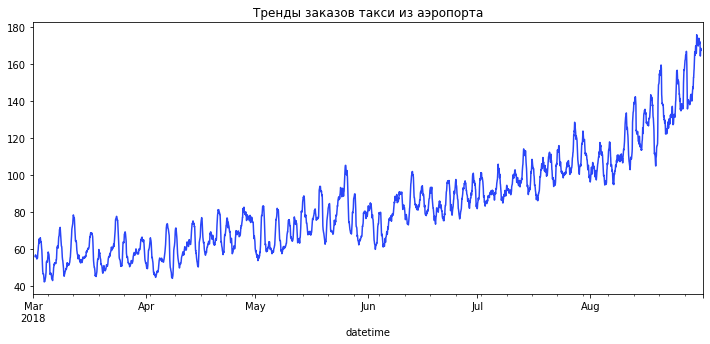

In [11]:
plt.figure(figsize=(12, 5))
decomposed_data.trend.plot(ax=plt.gca(), c=basic_color)
plt.title('Тренды заказов такси из аэропорта')
plt.show()

График изменения количества заказов такси отражает, что в течение месяца есть существенные колебания количества необходимых машин. Однако, в общем смысле количестве заказов в конце периода (в конце августа) возрасло примерно до 155 машин, по сравнению с 55 машинами - в марте.

Изучим есть ли каки-либо повторяющиеся колебания (сезонность).

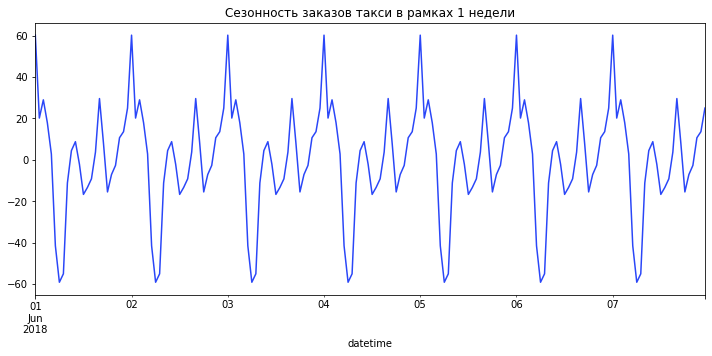

In [12]:
plt.figure(figsize=(12, 5))
decomposed_data.seasonal['2018-06-01':'2018-06-07'].plot(ax=plt.gca(), c=basic_color)
plt.title('Сезонность заказов такси в рамках 1 недели')
plt.show()

График заказов такси отражает, что в течение недели есть повторяемость по количеству такси, однако цикл повторения короче, чем неделя, изучим сезонность в рамках суток.

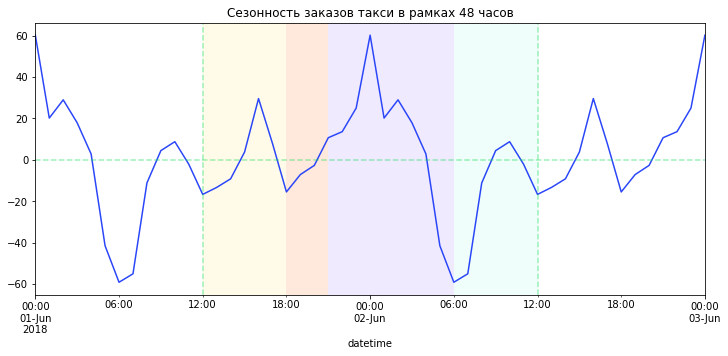

In [13]:
plt.figure(figsize=(12, 5))
decomposed_data.seasonal['2018-06-01 00:00:00': '2018-06-03 00:00:00'].plot(ax=plt.gca(), c=basic_color)
plt.title('Сезонность заказов такси в рамках 48 часов')
plt.axvline('2018-06-01 12:00:00', c=board_color, alpha=0.4, ls='--')
plt.axvline('2018-06-02 12:00:00', c=board_color, alpha=0.4, ls='--')
plt.axvspan('2018-06-01 12:00:00', '2018-06-01 18:00:00', facecolor=day_color, alpha=0.4)
plt.axvspan('2018-06-01 18:00:00', '2018-06-01 21:00:00', facecolor=evening_color, alpha=0.25)
plt.axvspan('2018-06-01 21:00:00', '2018-06-02 06:00:00', facecolor=night_color, alpha=0.15)
plt.axvspan('2018-06-02 06:00:00', '2018-06-02 12:00:00', facecolor=morning_color, alpha=0.3)
plt.axhline(0, c=board_color, alpha=0.4, ls='--')
plt.show()

Для удобства чтения графика сезонности такси в течении суток, пунктиром были ограничены сутки, а цветами (желтый, оранжевый, фиолетовый, голубой) были отмечены части дня (день, вечер, ночь и утро соответственно).

Есть очевидно повторяющаяся закономерность в течение суток. Так например максимальное количество машин вызывается в аэропорт в полночь(фактор полуночи повышает потребность в машинах на 60 единиц), на втором месте находятся пики в 16:00 и 02:00 - около 25 машин. 

Наименее активное время суток - промежуток времени между 04:00 и 08:00. Фактор раннего утра снижает потребность в такси на 40-60 машин. 

---
Существует мнение, что потребность в такси выше в определенные дни недели, например в пятницу - люди прилетают на выходные в короткое путешествие или в понедельник - стремятся прилететь и успеть на работу, или в командировку к началу недели. 

Для того чтобы выявить такую зависимость (или опровергнуть обозначенное мнение), проведем ресемплинг данных как сумма заказов по дню - и разделим данные на тренды и сезоны

In [14]:
df_day = df.copy()

In [15]:
df_day = df_day.resample('1D').sum()

In [16]:
df_day['day_of_week'] = df_day.index.dayofweek

<AxesSubplot:xlabel='datetime'>

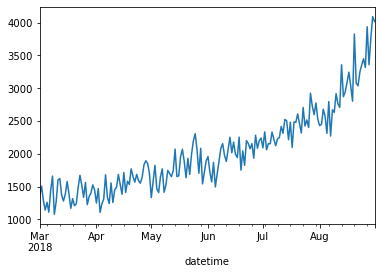

In [17]:
df_day['num_orders'].plot()

Тренды неизменны - и по дням и по часам.

In [18]:
decomposed_day = seasonal_decompose(df_day['num_orders'])

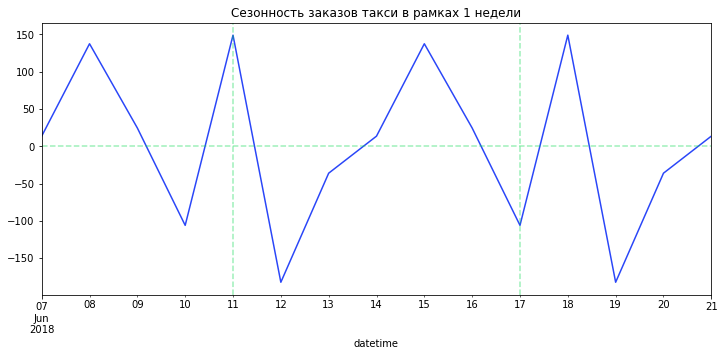

In [19]:
plt.figure(figsize=(12, 5))
decomposed_day.seasonal['2018-06-07':'2018-06-21'].plot(ax=plt.gca(), c=basic_color)
plt.title('Сезонность заказов такси в рамках 1 недели')
plt.axvline('2018-06-11', c=board_color, alpha=0.4, ls='--')
plt.axvline('2018-06-17', c=board_color, alpha=0.4, ls='--')
plt.axhline(0, c=board_color, alpha=0.4, ls='--')
plt.show()

На графике сезонности заказов такси в рамках 1 недели пунктирными линиями ограничена 1 неделя: с понедельника до воскресенья.

Очевидно, что день недели также влияет на потребность в такси: так например фактор понедельника увеличивает потребность в такси на 150 единиц в день, а фактор вторника - снижает потребность более, чем на 150 единиц.

---
Выявленные факторы сезонности будут выделены в качестве признаков для построения будущей модели прогнозирования.

Чтобы проанализировать сколько же в среднем мащин нужно каждый час - построим График потребности в такси методом скользящего среднего. Скользящее среднее рассчитано в рамках 24 часов, чтобы сгладить сезонность в рамках суток.

In [20]:
df['rolling_mean'] = df.rolling(24).mean()

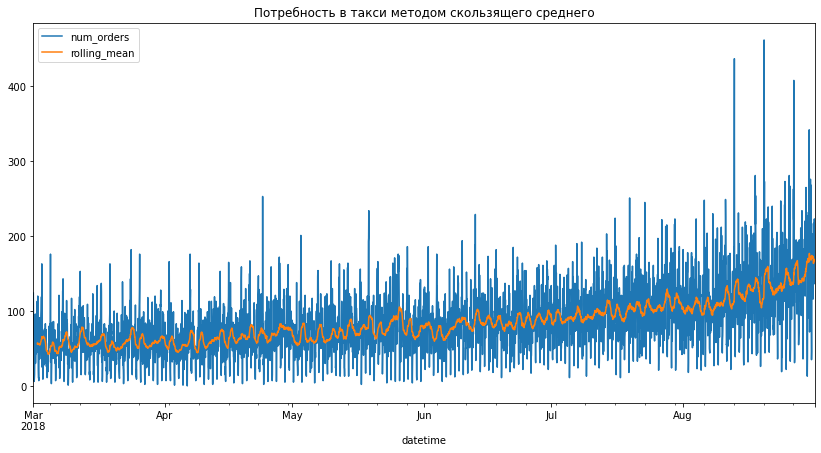

In [21]:
plt.figure(figsize=(14, 7))
df.plot(ax=plt.gca())
plt.title('Потребность в такси методом скользящего среднего')
plt.show()

График отражает что в марте в среднем было необходимо 60-80 такси в час, в летний период (особенно в августе) потребность в такси в аэропорту возрасла в среднем до 170 машин в час (не учитывая аномально высокие потребности в такси 15 и 20 августа).

In [22]:
df['rolling_mean'].describe()

count    4393.000000
mean       84.276083
std        26.335199
min        42.375000
25%        63.666667
50%        79.708333
75%        99.833333
max       176.916667
Name: rolling_mean, dtype: float64

Статистический метод аналитики подтверждает данные отраженные на графике: так например, медианное значение средней потребности за 6 месяцев составляло 80 машин, максимальное среднее - составило 177 машин (очевидно, эта цифра была в августе) - когда люди возвращаются из семейнх отпусков чтобы успеть приготовить детей к школе.

## Обучение

Создадим признаки для дальнейшего обучения модели. Выделим день месяца, день недели (чтобы учесть выявленную сезонность внутри недели), час (учесть сезонность внутри суток), а также добавим предыдущия значения - смещения до 6 часов (чтобы учесть направления трендов), а также скользящее среднее по 24 часам (также учесть возрастающие тренды)

In [23]:
df['day'] = df.index.day

In [24]:
df['dayofweek'] = df.index.dayofweek

In [25]:
df['hour'] = df.index.hour

In [26]:
for lag in range (1, 7):
    df['lag_{}'.format(lag)] = df['num_orders'].shift(lag)

In [27]:
df['rolling_mean'] = df['num_orders'].shift().rolling(24).mean()

In [28]:
df.head(25)

,num_orders,rolling_mean,day,dayofweek,hour,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6
datetime,,,,,,,,,,,
2018-03-01 00:00:00,124,NaN,1,3,0,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,NaN,1,3,1,124.0,NaN,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,NaN,1,3,2,85.0,124.0,NaN,NaN,NaN,NaN
2018-03-01 03:00:00,66,NaN,1,3,3,71.0,85.0,124.0,NaN,NaN,NaN
2018-03-01 04:00:00,43,NaN,1,3,4,66.0,71.0,85.0,124.0,NaN,NaN
2018-03-01 05:00:00,6,NaN,1,3,5,43.0,66.0,71.0,85.0,124.0,NaN
2018-03-01 06:00:00,12,NaN,1,3,6,6.0,43.0,66.0,71.0,85.0,124.0
2018-03-01 07:00:00,15,NaN,1,3,7,12.0,6.0,43.0,66.0,71.0,85.0
2018-03-01 08:00:00,34,NaN,1,3,8,15.0,12.0,6.0,43.0,66.0,71.0


In [29]:
df = df.dropna()

Разобьем данные на выборки. По условию проекта тестовая выборка составляет 10% от всей выборки

In [30]:
features = df.drop('num_orders', axis=1)
target = df['num_orders']

In [31]:
features_train, features_test, target_train, target_test = train_test_split(features, target, shuffle=False, test_size=0.1)

Построим несколько моделей машинного обучения, чтобы выбрать ту, которая покажет наименьшее значение RMSE на тестовой выборке (но не более 48).

### Catboost

Так как признаки день недели, день, час цикличны - то закодируем эти признаки через синус- косинус сектора.

In [32]:
features_train['day_sin'] = np.sin(features_train.day * (2. * np.pi / 30))
features_test['day_sin'] = np.sin(features_test.day * (2. * np.pi / 30))
features_train['day_cos'] = np.cos(features_train.day * (2. * np.pi / 30))
features_test['day_cos'] = np.cos(features_test.day * (2. * np.pi / 30))
features_train = features_train.drop('day', axis=1)
features_test = features_test.drop('day', axis=1)

In [33]:
features_train['dayofweek_sin'] = np.sin(features_train.dayofweek * (2. * np.pi / 7))
features_test['dayofweek_sin'] = np.sin(features_test.dayofweek * (2. * np.pi / 7))
features_train['dayofweek_cos'] = np.cos(features_train.dayofweek * (2. * np.pi / 7))
features_test['dayofweek_cos'] = np.cos(features_test.dayofweek * (2. * np.pi / 7))
features_train = features_train.drop('dayofweek', axis=1)
features_test = features_test.drop('dayofweek', axis=1)

In [34]:
features_train['hour_sin'] = np.sin(features_train.hour * (2. * np.pi / 24))
features_test['hour_sin'] = np.sin(features_test.hour * (2. * np.pi / 24))
features_train['hour_cos'] = np.cos(features_train.hour * (2. * np.pi / 24))
features_test['hour_cos'] = np.cos(features_test.hour * (2. * np.pi / 24))
features_train = features_train.drop('hour', axis=1)
features_test = features_test.drop('hour', axis=1)

In [35]:
features_train.head()

,rolling_mean,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,day_sin,day_cos,dayofweek_sin,dayofweek_cos,hour_sin,hour_cos
datetime,,,,,,,,,,,,,
2018-03-02 00:00:00,56.833333,58.0,113.0,66.0,61.0,45.0,73.0,0.406737,0.913545,-0.433884,-0.900969,0.000000,1.000000
2018-03-02 01:00:00,55.416667,90.0,58.0,113.0,66.0,61.0,45.0,0.406737,0.913545,-0.433884,-0.900969,0.258819,0.965926
2018-03-02 02:00:00,56.875000,120.0,90.0,58.0,113.0,66.0,61.0,0.406737,0.913545,-0.433884,-0.900969,0.500000,0.866025
2018-03-02 03:00:00,57.041667,75.0,120.0,90.0,58.0,113.0,66.0,0.406737,0.913545,-0.433884,-0.900969,0.707107,0.707107
2018-03-02 04:00:00,56.958333,64.0,75.0,120.0,90.0,58.0,113.0,0.406737,0.913545,-0.433884,-0.900969,0.866025,0.500000


In [36]:
cb = CatBoostRegressor(loss_function='RMSE', verbose=100, iterations=2000, learning_rate=0.5, depth=8, early_stopping_rounds=3)

In [37]:
%%time
cb.fit(features_train, target_train)

0:	learn: 30.1460326	total: 107ms	remaining: 3m 33s
100:	learn: 9.1706710	total: 1.36s	remaining: 25.5s
200:	learn: 4.5882672	total: 2.62s	remaining: 23.5s
300:	learn: 2.4597862	total: 3.89s	remaining: 22s
400:	learn: 1.3657155	total: 5.15s	remaining: 20.6s
500:	learn: 0.7472353	total: 6.46s	remaining: 19.3s
600:	learn: 0.4152683	total: 7.76s	remaining: 18.1s
700:	learn: 0.2406633	total: 9.05s	remaining: 16.8s
800:	learn: 0.1383294	total: 10.3s	remaining: 15.5s
900:	learn: 0.0777287	total: 11.6s	remaining: 14.1s
1000:	learn: 0.0442059	total: 12.8s	remaining: 12.8s
1100:	learn: 0.0265617	total: 14.1s	remaining: 11.5s
1200:	learn: 0.0156664	total: 15.3s	remaining: 10.2s
1300:	learn: 0.0090909	total: 16.5s	remaining: 8.88s
1400:	learn: 0.0051697	total: 17.8s	remaining: 7.59s
1500:	learn: 0.0030103	total: 19.1s	remaining: 6.36s
1600:	learn: 0.0017265	total: 20.4s	remaining: 5.08s
1700:	learn: 0.0009969	total: 21.6s	remaining: 3.79s
1800:	learn: 0.0005777	total: 22.8s	remaining: 2.52s
1900:

In [38]:
predictions_test_cb = cb.predict(features_test)

In [39]:
rmse_cb = mean_squared_error(target_test, predictions_test_cb)**0.5
rmse_cb

43.77102944257101

**Catboost** показал предсказание с **RMSE = 44.9**

### Линейная регрессия

In [40]:
model = LinearRegression()
model.fit(features_train, target_train)

LinearRegression()

In [41]:
predictions_test_lr = model.predict(features_test)

In [42]:
rmse_lr = mean_squared_error(target_test, predictions_test_lr)**0.5
rmse_lr

48.6870301974211

Методом линейной регрессии разработана модель с **RMSE = 48.6** на тестовой выборке, что очевидно хуже, чем результат Catboost, и выше, чем условия проекта.

### Случайный лес

In [43]:
random_grid = {'n_estimators':[10, 17, 25],
               'max_depth':[5, 9, 20],
               'bootstrap':[True, False],
               'min_samples_leaf':[1, 5]
              }

In [44]:
forest_model = RandomForestRegressor(random_state=42)

In [45]:
forest_random = RandomizedSearchCV(estimator = forest_model, param_distributions = random_grid, n_iter = 36, 
                                   cv = TimeSeriesSplit(n_splits=8), verbose=2, random_state=42, n_jobs = -1)

In [46]:
forest_random.fit(features_train, target_train)

Fitting 8 folds for each of 36 candidates, totalling 288 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    7.0s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   21.3s
[Parallel(n_jobs=-1)]: Done 288 out of 288 | elapsed:   43.0s finished


RandomizedSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=8),
                   estimator=RandomForestRegressor(random_state=42), n_iter=36,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [5, 9, 20],
                                        'min_samples_leaf': [1, 5],
                                        'n_estimators': [10, 17, 25]},
                   random_state=42, verbose=2)

In [47]:
forest_random.best_params_

{'n_estimators': 25, 'min_samples_leaf': 5, 'max_depth': 20, 'bootstrap': True}

In [48]:
predictions_test_forest = forest_random.predict(features_test)

In [49]:
rmse_forest = mean_squared_error(target_test, predictions_test_forest)**0.5
rmse_forest

43.527166928311864

Случайный лес показал неплохой **RMSE = 43.5** на тестовой выборке, и это немного лучше, чем результат Catboost.

### ARIMA

In [50]:
model_arima = ARIMA(target_train, order=(6,1,3))

In [51]:
model_arima_fit = model_arima.fit(disp=0)

In [52]:
predictions_arima = []
for i in range(len(target_test)):
    output = model_arima_fit.forecast()
    predictions_arima.append(output[0])

In [53]:
rmse_arima = mean_squared_error(target_test, predictions_arima)**0.5
rmse_arima

58.958683463338176

Построенная в качестве эксперимента модель ARIMA показала RMSE = 58.9, что сильно выше, чем ограничения в проекте.

Подбор параметров для ARIMA оказался очень времязатратным.

**Общий вывод**
Наилучший показатель RMSE = 44 удалось достигнуть, построив модели на основе CatBoost и Случайный лес с подбором параметров через кросс-валидацию. В дальнейшем будем проверять CatBoost

## Тестирование

Так как все построенные ранее модели уже рассчитали RMSE на тестовой выборке, в качестве тестирования проверим выбранную модель на адекватность. 

In [54]:
predictions_cb = cb.predict(features_test)

Представим, что модель предсказывает константу - медианное значение обучающей выборки. рассчитаем RMSE константной модели

In [55]:
predictions_constant = np.ones(target_test.shape[0]) * target_train.median()

In [56]:
rmse_constant = mean_squared_error(target_test, predictions_constant)**0.5
rmse_constant

87.21093811714634

RMSE константной модели составило 87.2, что очевидно хуже, чем точность нашей модели. Наша модель работает более адекватно, чем просто предсказание медианы

---

Если же предложить нашей модели предсказывать значения по предыдущему часу:

In [57]:
predictions_cb_shift = target_test.shift(fill_value=0)

In [58]:
rmse_shift = mean_squared_error(target_test, predictions_cb_shift)**0.5
rmse_shift

59.262187085711055

RMSE такой модели составляет 59.3 - что значительно выше условий проекта, и выше чем показатель нашей модели.